# In this notebook you will learn about the redispatching and curtailment capabilities offered by grid2op.
Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/Grid2Op/grid2op/master)

**Objectives**

In the previous notebooks, we presented actions in a discrete action space. However, more actions are available in Grid2Op. Redispatching and curtailment are kind of continuous action that will be described here.

This notebook will:

- [I) Redispatching](#redispatching) details redispatching
    - present what redispatching is
    - show how it can be used in grid2op
    - detail the redispatching actions
    - show an example of a redispatching Agent
- [II) Curtailment](#curtailment) explains the curtailment
    - show the behaviour of the curtailment: how to perform it, what is does etc.
    - expose some limits of this curtailment: it can break the grid easily !

<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">
Execute the cell below by removing the # character if you use google colab !

Cell will look like:
```python
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)
```
<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">

In [1]:
# !pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)

In [2]:
import os
import sys
import grid2op
from grid2op.Agent import DoNothingAgent, BaseAgent
from tqdm.notebook import tqdm  # for easy progress bar
display_tqdm = False  # this is set to False for ease with the unitt test, feel free to set it to True
import numpy as np
max_iter = 100  # to make computation much faster we will only consider 100 time steps
import pdb
import matplotlib.pyplot as plt

In [3]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

# I) Redispatching  <a class="anchor" id="redispatching"></a>

## How to implement redispatch actions

### Having a suitable environment

By default, some environments do not specify the cost of generators, their maximum and minimum production values, etc. In this case it is not possible to redispatch in grid2op.

To know more about what is needed for using redispatching, it is advised to look at this help online : https://grid2op.readthedocs.io/en/latest/space.html#grid2op.Space.GridObjects.redispatching_unit_commitment_availble for the most recent documentation. When this notebook was created, the following were needed:

- "gen_type": the type of generator
- "gen_pmin": the minimum value a generator can produce
- "gen_pmax" : the maximum value a generator can produce
- "gen_redispatchable": whether this generator can be dispatched
- "gen_max_ramp_up": the maximum increase of power a generator can have between two consecutive time steps
- "gen_max_ramp_down": the maximum decrease of power a generator can have between two consecutive time steps
- "gen_min_uptime": the minimum time a generator needs to be turned on (it's impossible to disconnect it if it's not connected for a least "gen_min_uptime" consecutive time step)
- "gen_min_downtime": same as above, but for downtime
- "gen_cost_per_MW": the generation cost. For each MW of electricity produced in a time step, this is the amount paid
- "gen_startup_cost": the cost to start a generator
- "gen_shutdown_cost": the cost to shutdown a generator

We made available a dedicated environment, based on the IEEE case14 powergrid that has all this features. It is advised to use this small environment for testing and getting familiar with redispatching.

This environment includes 5 generators, as the original case14 system. It has one solar generator and one wind generator (that cannot be dispatched), one nuclear powerplant (dispatchable) and 2 thermal generators (also dispatchable). Thus, redispatching is a problem of continuous control with 3 degress of freedom here.

In [4]:
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend

env_name = "l2rpn_case14_sandbox"
env = grid2op.make(env_name, test=True, backend=bk_cls())

print("Is this environment suitable for redispatching: {}".format(env.redispatching_unit_commitment_availble))

c:\Users\admin\Grid2Op\venv_grid2op\lib\site-packages\grid2op\MakeEnv\Make.py:454: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Is this environment suitable for redispatching: True


As we can see, this environment is suitable for redispatching. It means that all quantities described above are set (and visible).

In the L2RPN 2019 challenges, we rewarded participants based on the use of the powerlines. In next challenges, or for other uses of this platform where redispatching should be considered, it's better to consider the economic cost of the sytem as an evaluation metric. However, usually a cost should be minimized, while a reward should be maximized. To take this into account, a simple reward named "EconomicReward" has been created. It has the following properties:

- it returns -1 if there has been a game over
- otherwise (there has been no game over, no errors, etc) it is always strictly positive
- maximizing this reward is equivalent to minimizing the cost

Note that this reward doesn't take into account the cost to perform a redispatching action. This reward can be used to build what is called an "economic dispatch", a problem that is particularly interesting for electricity producers but of lower interest for Transmission System Operators (as opposed to the topology).

Compared to standard "economic dispatch" problems, for now storages are not implemented (coming soon) and we don't fully take into account the startup cost, shutdown cost, as well as minimum downtime and minimum uptime (even though all of these features are implemented). Also, note that redispatching is implemented in differences, meaning that you first need to provide an economic dispatch, and then think in terms of variations from that point onward. This is the usage that will be explained in this notebook. For real unit commitment / economic dispatch problems, the key words "injections" / "prod_p" for the action would probably be more suited.

### Redispatching implementation

Unlike topological actions which are always feasible (this is an assumption that is made in this package), redispatching actions are limited by physical constraints on the generators. For example:

- it is not possible for a generator to produce more (resp. less) than pmax (resp. pmin). Unlike the curent flow on the powerline, this is a strict physical constraint.
- it is not possible for the same physical limitations to increase (or decrease) too much the value between two consecutive time steps.
- redispatching actions stack with one another. It means that if you ask to increase the production of the generator 1 by $10MW$ at time step t, and by $20MW$ at time step $t+1$, it means that the set point at time step $t+1$ will be $+30MW$ higher than if no redispatching had been made (it would have been only $+10MW$ higher if the second redispatching action had not been performed).

That being said, much can happen that makes redispatching a bit less trivial than topology changes:
- When you do a redispatching action, you don't know what the time series of the environment looks like. For example, say the pmax of generator 1 is 100. The setpoint of this generator at time t is $60MW$, and you want to increase its value by another $40MW$. This action is legal: $60+40 \leq pmax (=100) $. So at time $t$ everything is fine. Now let's suppose that the environment also moved the setpoint of this same generator from $60$ to be at $70MW$ at time $t+1$. With the redispatching action, this would mean that the setpoint would be $70+40 = 110 > pmax$. This is not possible. In this case, the redispatching action will be capped : instead of the desired redispatching of $+40$, only a smaller redispatching of $+30$ will be implemented on the powergrid. 
- Another problem can arise with the fundamental principle of power grid: power energy cannot be stored in a grid. At each time we then have $\sum \text{Prod} = \sum \text{Load} + \text{Losses}$. In this competition, the data is generated such that this condition holds (approximately) for all time steps. This means that if you ask for a redispatching of +xxx MW on a given generator, then the other ones must compensate and "absorb" xxx MW such that it sums to 0 overall.

Out of simplicity for the participants, there are some built-in control mechanisms and functions ("automatons") that automatically transform an proposed redispatching action into a valid redispatching action. 

These automatons basically ensure that the two above-mentionned conditions hold. It explains the differences between "target_redispatching" which is the desired setpoint enter by the agent, and the "actual_redispatching" which is the one that has actually been implemented on the powergrid after it has been corrected by the automatons.

### More cases for ambiguous actions

In [5]:
env.gen_redispatchable

array([ True,  True, False, False, False,  True])

The above vector tells which generator is dispatchable and which is not. Any attempt to dispatch a generator that is not dispatchable leads to an ambiguous action.

In [6]:
act = env.action_space({"redispatch": [(2, +10)]})
act.is_ambiguous()

(True,
 Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('Trying to apply a redispatching action on a non redispatchable generator'))

In [7]:
act

As we see, this action is ambiguous because we are `Trying to apply a redispatching action on a non redispatchable generator`. Indeed, as shown above, the generator 2 is not dispatchable.

Generators also have physical constraints. You cannot ask them to change the active production value too fast, this would damage the generator, and breaking a nuclear plant is often a terrible idea. In grid2op it is implemented as an ambiguous action. Trying to go beyond this value will result in an ambiguous action.

This value is called the "ramp" and it's available through the "max_ramp_up" attribute. On the next cell, you can see that the ramp is $5MW$ for the first generator and $10MW$ for the second one and the last one. For the other 2 it's irrelevant because they are not dispatchable.

In [8]:
env.gen_max_ramp_up

array([ 5., 10.,  0.,  0.,  0., 15.], dtype=float32)

Any attempt to go beyond this value will raise an ambiguous error :

In [9]:
act = env.action_space({"redispatch": [(0, +10)]})
act.is_ambiguous()

(True,
 Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('Some redispatching amount are above the maximum ramp up'))

In the previous action, we asked the generator 0 to increase its setpoint by $10MW$. However, its maximum ramp up is only $5MW$. Thus, this action is ambiguous.

Of course, there are some perfectly valid redispatching actions:

In [10]:
act = env.action_space({"redispatch": [(1, +10)]})
act.is_ambiguous()

(False, None)

### The (desired) setpoint is not the actual setpoint

As said in the preamble of this section, the target dispatching, what we want to achieve (the target), is not equal to the implemented dispatching. So that we can see the operations that are actually being performed, both of these values are present in the observation, as shown in the cell below.

In [11]:
observed = []
# perform a valid redispatching action
env.set_id(0)  # make sure to use the same environment input data.
obs_init = env.reset()  # reset the environment
act = env.action_space()
act = env.action_space({"redispatch": [(0, -5)]})
obs, reward, done, info = env.step(act)
print("actual dispatch at time step 0: {}".format(obs.actual_dispatch))
observed.append(obs)

actual dispatch at time step 0: [-5.        2.000002  0.        0.        0.        2.999998]


The target dispatch is exactly what we wanted, e.g. the generator 0 has decreased its production by $5MW$. To compensate for this increase, both generator 1 has increase its production of 2MW and generator 5 of 3 MW.

Let's plot the generators' base productions in this environment data (*ie* without any intervention from the agent), and what is implemented with the current redispatching :

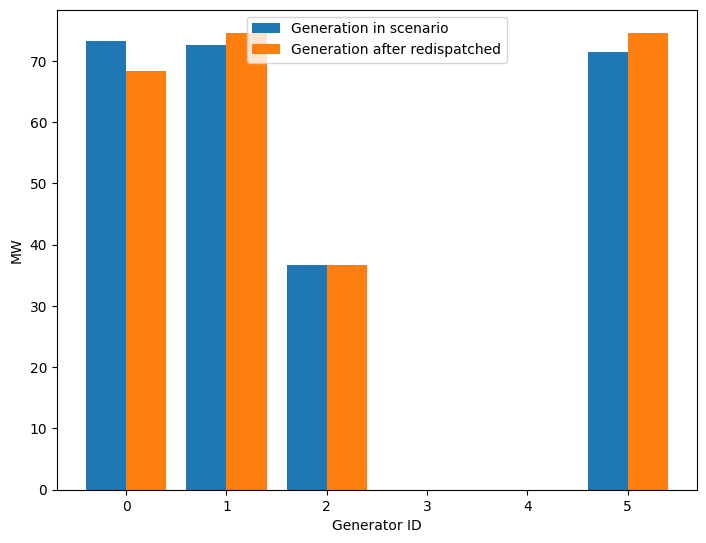

In [12]:
# Create a matplot figure
redisp_fig = plt.figure()
ax = redisp_fig.add_axes([0,0,1,1])
# X axis is the generators
x_gens = np.arange(obs.n_gen)
# Y axis is the production in MW
y_scenario_p = obs.gen_p - obs.actual_dispatch
y_redisp_p = obs.gen_p
# Blue bars for scenario productions
ax.bar(x_gens - 0.2, y_scenario_p, width = 0.4)
# Red bars for production with redispatch
ax.bar(x_gens + 0.2, y_redisp_p, width = 0.4)
# Set some legend to describe what's above
ax.set_ylabel('MW')
ax.set_xlabel('Generator ID')
_ = ax.legend(labels=['Generation in scenario', 'Generation after redispatched'])

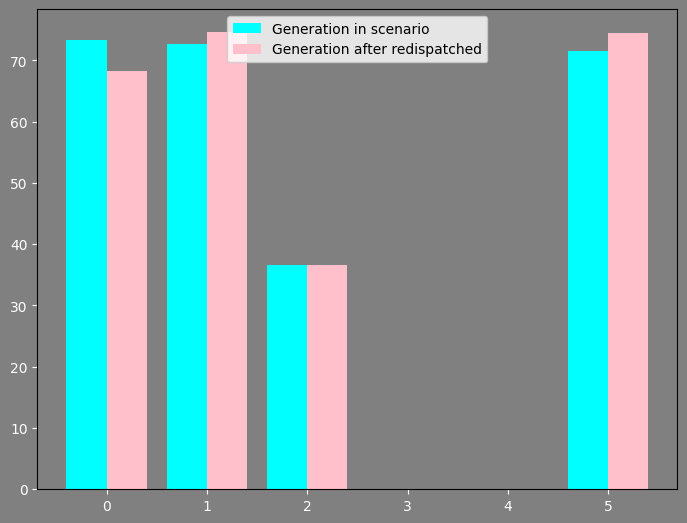

In [13]:
redisp_fig = plt.figure(facecolor='gray')
ax = redisp_fig.add_axes([0, 0, 1, 1], facecolor='gray')

# Set axis and text colors to white
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

# Set the bar and grid colors accordingly
ax.bar(x_gens - 0.2, y_scenario_p, width=0.4, color='cyan')
ax.bar(x_gens + 0.2, y_redisp_p, width=0.4, color='pink')

# Set legend color text to black
legend = ax.legend(labels=['Generation in scenario', 'Generation after redispatched'])
for text in legend.get_texts():
    text.set_color('black')


In the following cell, we won't be performing any redispatching action. We will simply do nothing. This example is here to illustrate that grid2op will continue to apply the previous redispatching configuration over time, until the original redispatching action is removed (i.e. until the opposite command is sent).

In [14]:
donothing = env.action_space()
obs1, reward, done, info = env.step(donothing)
print("actual dispatch at time step 1: {}".format(obs1.actual_dispatch))
observed.append(obs1)
obs2, reward, done, info = env.step(donothing)
print("actual dispatch at time step 2: {}".format(obs2.actual_dispatch))
observed.append(obs2)
obs3, reward, done, info = env.step(donothing)
print("actual dispatch at time step 2: {}".format(obs2.actual_dispatch))
observed.append(obs3)

actual dispatch at time step 1: [-5.        2.000002  0.        0.        0.        2.999998]
actual dispatch at time step 2: [-5.        2.000002  0.        0.        0.        2.999998]
actual dispatch at time step 2: [-5.        2.000002  0.        0.        0.        2.999998]


Here, the original redispatching action was to increase the setpoint of generator 0 by $5MW$. If we want to remove this, we need to decrease its setpoint by $5MW$ :

In [15]:
act = env.action_space({"redispatch": [(0, 5)]})
obs3, reward, done, info = env.step(act)
print("actual dispatch at time step 3: {}".format(obs3.actual_dispatch))
observed.append(obs3)

actual dispatch at time step 3: [-0.3999439   0.19997184  0.          0.          0.          0.19997205]


As we see in the cell above, there are still residuals on the dispatch. 

This is because of the physical limit of the ramp of the generator 0. 

We wanted it to return to its original setpoint value, but at the same time step, the "environment" (representing a market for example) also modified the setpoint of this generator by +0.3MW. 

Therefore, the total desired increase for the setpoint of generator 0 was $5+0.4 = 5.4 > max\_ramp\_down$. The action (that would increase the production of 5.4 MW) could not completely performed. Grid2op "capped" the redispatch occuring at this timestep to $5MW$ (max\_ramp\_down) leaving a remaining of -0.4MW (instead of the initial -5.)

That is why we can see a small part of the dispatch left. If we wait for another timestep and do nothing, the generator will likely be in order.

In [16]:
obs4, reward, done, info = env.step(donothing)
print("actual dispatch at time step 4: {}".format(obs4.actual_dispatch))
observed.append(obs4)
obs5, reward, done, info = env.step(donothing)
print("actual dispatch at time step 5: {}".format(obs5.actual_dispatch))
observed.append(obs5)

actual dispatch at time step 4: [ 0.          0.03999412  0.          0.          0.         -0.03999412]
actual dispatch at time step 5: [ 0.          0.03999412  0.          0.          0.         -0.03999412]


Now everything is set up as it should be. The system is back to its original state. Let's see what happens if we ask to decrease again the value of this generator 0.

In [17]:
act = env.action_space({"redispatch": [(0, -5.)]})
obs6, reward, done, info = env.step(act)
print("actual dispatch at time step 6: {}".format(obs6.actual_dispatch))
observed.append(obs6)
obs7, reward, done, info = env.step(donothing)
print("actual dispatch at time step 7: {}".format(obs7.actual_dispatch))
observed.append(obs7)
obs8, reward, done, info = env.step(donothing)
print("actual dispatch at time step 8: {}".format(obs8.actual_dispatch))
observed.append(obs8)

actual dispatch at time step 6: [-4.4000516  1.740022   0.         0.         0.         2.6600296]
actual dispatch at time step 7: [-5.         1.9800016  0.         0.         0.         3.0199986]
actual dispatch at time step 8: [-5.         1.9800016  0.         0.         0.         3.0199986]


This time we see that the full (valid) redispatching action is not applied completely. 

This is due to the same phenomenon that occurred previously. The environment (*eg* a market or a central authority) decreased the value of this generator and at the same time, we (=an agent operating the grid in real time) also asked to decrease it by its "max ramp up" value. 

Consequently, our action was "capped" and only  4.4MW (out of 5MW) were indeed removed to the generator's production. 

At the next time step (step 7), the action is fully implemented.

To conclude on redispatching, we saw that there is a difference between the value we ask for, and the value that is implemented by the environment. This is mainly because:

- the implemented vector should sum to 0.
- if a redispatching is close to the maximum value it can take (due to ramping limitation or hard limitations) and if at the same time the environment itself "wants" to increase this value, physical limitations have to be respected.

Redispatching actions also last in time. One action must be explicitely canceled to be reset to 0. This cancellation can take a few time steps to be fully effective as of the limitations mentionned above.

To summarize, we can look at the productions over time for generators 0 & 5:

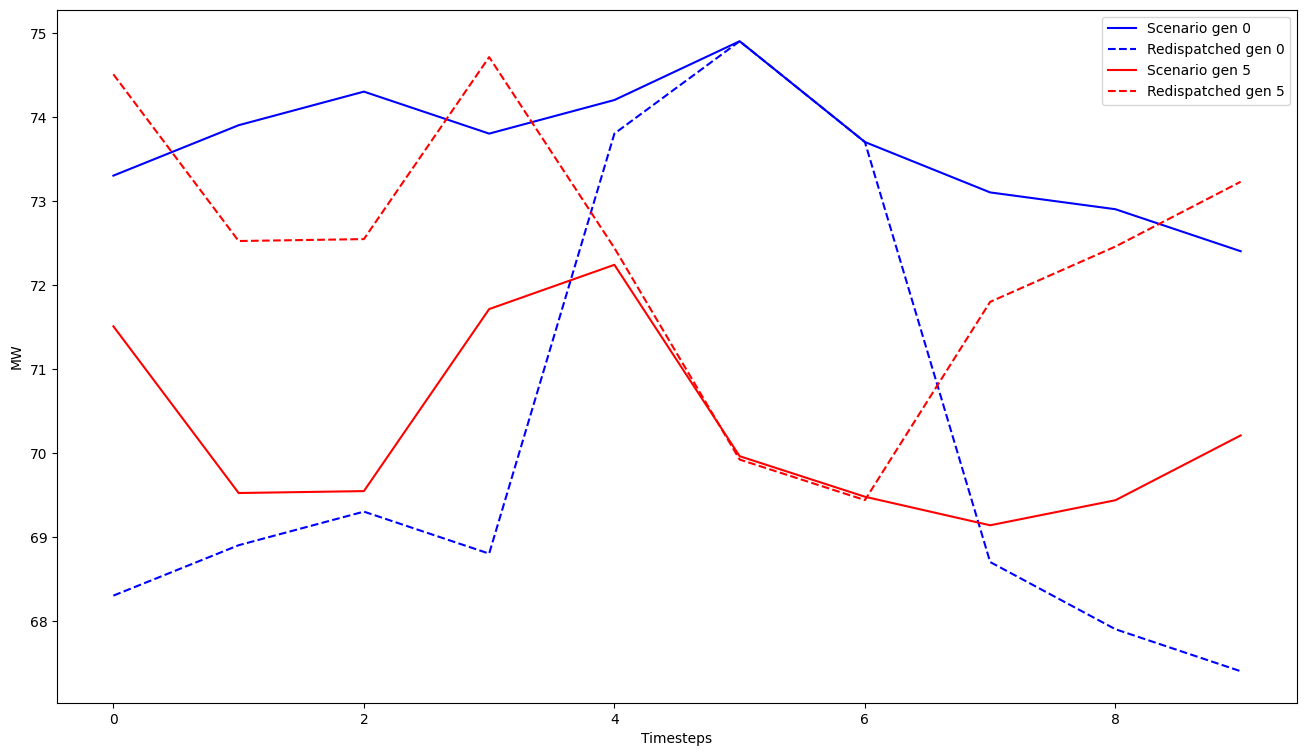

In [18]:
# Create a matplot figure
redisp_fig = plt.figure(figsize=(16, 9))
# X axis is the timesteps
x_gens = np.arange(len(observed), dtype=np.int32)
# Y axis is the production in MW
y_scenario_p_0 = [o.gen_p[0] - o.actual_dispatch[0] for o in observed] 
y_redisp_p_0 = [o.gen_p[0] for o in observed]
y_scenario_p_4 = [o.gen_p[5] - o.actual_dispatch[5] for o in observed] 
y_redisp_p_4 = [o.gen_p[5] for o in observed]
# Blue lines for gen 0
plt.plot(x_gens, y_scenario_p_0, 'b', x_gens, y_redisp_p_0, 'b--')
# Red lines for gen 4
plt.plot(x_gens, y_scenario_p_4, 'r', x_gens, y_redisp_p_4, 'r--')
# Set some legend to describe what's above
plt.ylabel('MW')
plt.xlabel('Timesteps')
_ = plt.legend(labels=['Scenario gen 0', 'Redispatched gen 0', 'Scenario gen 5', 'Redispatched gen 5'])

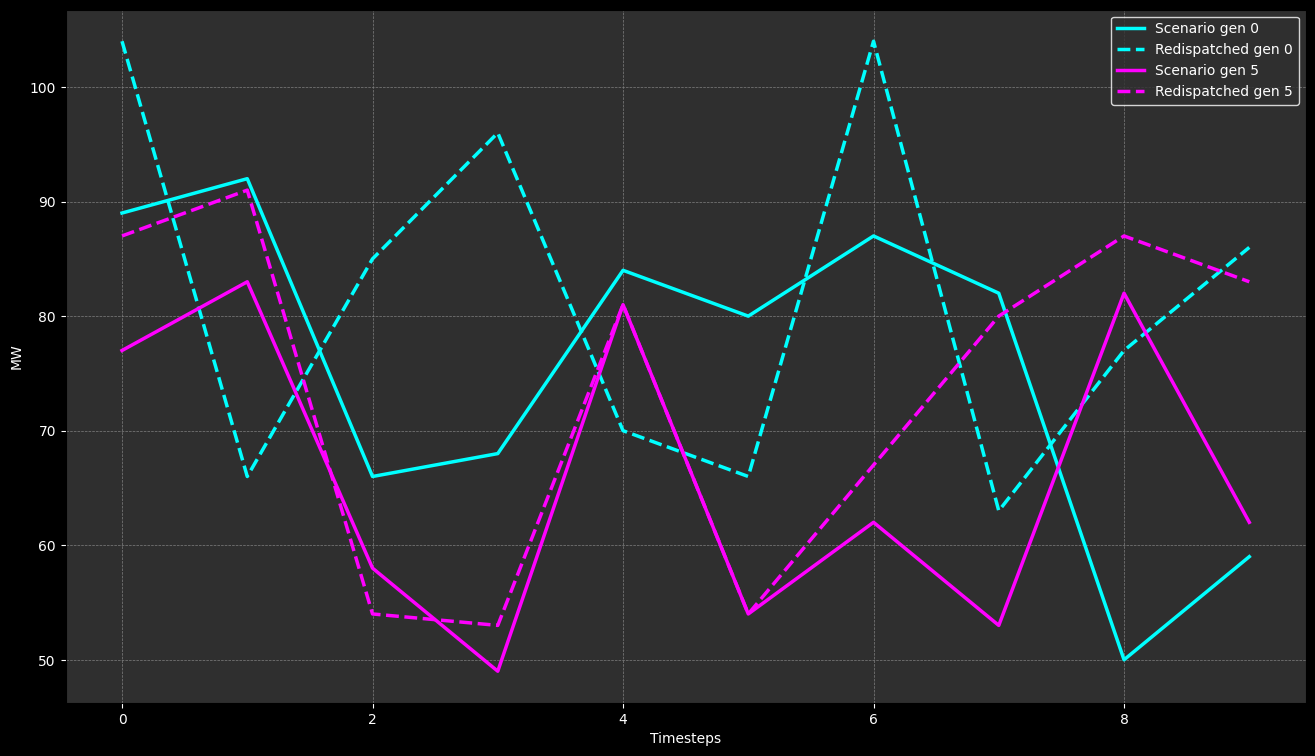

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with a black background
redisp_fig = plt.figure(figsize=(16, 9), facecolor='black')

# Dummy data for plotting
x_gens = np.arange(10, dtype=np.int32)
y_scenario_p_0 = np.random.randint(50, 100, size=10)
y_redisp_p_0 = np.random.randint(60, 110, size=10)
y_scenario_p_4 = np.random.randint(40, 90, size=10)
y_redisp_p_4 = np.random.randint(45, 95, size=10)

# Create axes with a darker gray background
ax = redisp_fig.add_subplot(1, 1, 1, facecolor='#2f2f2f')

# Plot with custom line widths for better visibility
ax.plot(x_gens, y_scenario_p_0, 'cyan', linewidth=2.5, label='Scenario gen 0')
ax.plot(x_gens, y_redisp_p_0, 'cyan', linestyle='--', linewidth=2.5, label='Redispatched gen 0')
ax.plot(x_gens, y_scenario_p_4, 'magenta', linewidth=2.5, label='Scenario gen 5')
ax.plot(x_gens, y_redisp_p_4, 'magenta', linestyle='--', linewidth=2.5, label='Redispatched gen 5')

# Set axis labels and colors
ax.set_ylabel('MW', color='white')
ax.set_xlabel('Timesteps', color='white')

# Customize ticks and grid
ax.tick_params(colors='white')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Set legend with white text and dark background
legend = ax.legend(facecolor='#2f2f2f', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.show()


## Example of use: economic dispatch problem

**NB** This is an illustration of an economic dispatch problem that can use grid2op. The problems modeled in the L2RPN competitions are NOT economic dispatch.

In [20]:
agent = DoNothingAgent(env.action_space)
done = False
reward = env.reward_range[0]

env.set_id(0)  # make sure to evaluate the models on the same experiments
obs = env.reset()
cum_reward = 0
nrow = env.chronics_handler.max_timestep() if max_iter <= 0 else max_iter
gen_p = np.zeros((nrow, env.n_gen))
gen_p_setpoint = np.zeros((nrow, env.n_gen))
load_p = np.zeros((nrow, env.n_load))
rho = np.zeros((nrow, env.n_line))
i = 0
with tqdm(total=max_iter, desc="step", disable=not display_tqdm) as pbar:
    while not done:
        act = agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)
        data_generator = env.chronics_handler.real_data.data
        gen_p_setpoint[i,:] = data_generator.prod_p[data_generator.current_index, :]
        gen_p[i,:] = obs.gen_p
        load_p[i,:] = obs.load_p
        rho[i,:] = obs.rho
        cum_reward += reward
        i += 1
        pbar.update(1)
        if i >= max_iter:
            break
print("The cumulative reward with this agent is {:.0f}".format(cum_reward))

The cumulative reward with this agent is 7040


Now let's try to redispatch as much production as possible to the cheapest generator, and leave the rest unchanged.

In [21]:
class GreedyEconomic(BaseAgent):
    def __init__(self, action_space):
        super().__init__(action_space)
        self.do_nothing = action_space()
        
    def act(self, obs, reward, done):
        act = self.do_nothing
        if obs.gen_p[0] < obs.gen_pmax[0] - 1 and \
        obs.target_dispatch[0] < (obs.gen_pmax[0] - obs.gen_max_ramp_up[0]) - 1 and\
        obs.gen_p[0] > 0.:
            # if the cheapest generator is significantly bellow its maximum cost
            if obs.target_dispatch[0] < obs.gen_pmax[0]:
                #in theory i can still ask for more
                act = env.action_space({"redispatch": [(0, obs.gen_max_ramp_up[0])]})
        return act
    
agent = GreedyEconomic(env.action_space)
done = False
reward = env.reward_range[0]

env.set_id(0) # reset the env to the same id
obs = env.reset()
cum_reward = 0
nrow = env.chronics_handler.max_timestep() if max_iter <= 0 else max_iter
gen_p = np.zeros((nrow, env.n_gen))
gen_p_setpoint = np.zeros((nrow, env.n_gen))
load_p = np.zeros((nrow, env.n_load))
rho = np.zeros((nrow, env.n_line))
i = 0
with tqdm(total=max_iter, desc="step", disable=not display_tqdm) as pbar:
    while not done:
        act = agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)
        data_generator = env.chronics_handler.real_data.data
        gen_p_setpoint[i,:] = data_generator.prod_p[data_generator.current_index, :]
        gen_p[i,:] = obs.gen_p
        load_p[i,:] = obs.load_p
        rho[i,:] = obs.rho
        cum_reward += reward
        i += 1
        pbar.update(1)
        if i >= max_iter:
            break
            
print("The cumulative reward with this agent is {:.0f}".format(cum_reward))

The cumulative reward with this agent is 5369


As we can see, that second agent performed worse than the `DoNothing` agent, demonstrating that having the cheapest generators produce the most energy is not always the best solution.

# II Curtailment  <a class="anchor" id="curtailment"></a>

Quite like redispatching, curtailment is a type of action that can act on generators. As opposed to redispatching it acts on generators coming from renewable energy sources.

The idea behind the curtailment is to limit the production of some generators to a certain upper bound. In real world application, such actions can be performed in case of emergency: when a powerline evacuating a wind farm is on overflow, it can be necassary to reduce the production the this wind farm even though we could have produced more.

**NB** As for everything related to grid2op, we adopt the TSO point of view and model real time. This implies that the offer / demand equilibrium has been already computed. If the agent can not act, then the offer matches the demand already. Curtailment here is to understand as a real time security measure.

If you want a detailed description of the modeling of the curtailment you can visit the official documentation [here](https://grid2op.readthedocs.io/en/latest/modeled_elements.html#generators)

First let's see how you can apply a curtailment action in mainly 4 different ways. For the sake of the example, imagine we limit the production of the generator 2 at 10% of its maximum generation.

In [22]:
import grid2op
from grid2op.Action import PlayableAction
from grid2op.Parameters import Parameters
import matplotlib.pyplot as plt

param = Parameters()
param.NO_OVERFLOW_DISCONNECTION = True
env1 = grid2op.make("educ_case14_storage",
                    test=True,
                    action_class=PlayableAction,
                    param=param,
                    backend=bk_cls())

gen_id = 2  # because we want to act on generator 2
amount_ratio = 0.1  # that is the 7% of the limit

# method 1
curtail_act_1 = env1.action_space({"curtail": [(gen_id, amount_ratio)]})

# method 2
curtail_vect = np.zeros(env1.n_gen) - 1.
curtail_vect[gen_id] = amount_ratio
curtail_act_2 = env1.action_space({"curtail": curtail_vect})

# method 3
curtail_act_3 = env1.action_space()
curtail_act_3.curtail = [(gen_id, amount_ratio)]


# method 4
curtail_act_4 = env1.action_space()
curtail_act_4.curtail = curtail_vect

# all these actions are equal
print(curtail_act_4)

c:\Users\admin\Grid2Op\venv_grid2op\lib\site-packages\grid2op\MakeEnv\Make.py:454: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - Perform the following curtailment:
	 	 - Limit unit "gen_5_2" to 10.0% of its Pmax (setpoint: 0.100)
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


One "side effect" of applying a curtailment action can be redispatching. Indeed, the balance between production and load should maintain. The data (before curtailment) meets this criteria. This means that whatever curtailment is performed should be absorbed somehow. 

We decided to have the dispatchable generators produce more to compensate the curtailment. This behaviour is showed in the cell below.

In [23]:
env1.set_id(0)
obs_init = env1.reset()
obs, *_ = env1.step(curtail_act_1)
print(f"Amount of MW curtailed for generator {gen_id}: {obs.curtailment_mw[gen_id]:.2f} MW")
print(f"Sum of redispatched generator: {obs.actual_dispatch.sum():.2f} MW")

Amount of MW curtailed for generator 2: 9.90 MW
Sum of redispatched generator: 9.90 MW


Finally, curtailment action will perdure on time. This means that if you perform a curtailment action on a step, unless you modify it later on. 

In this example above, the generator with id 2 will be constrained to produce less than 15% of its maximum production until you change that.

We explain it in the cell below:

Curtailment setpoint for generator 2: 0.10 (7.00 MW)
Curtailment setpoint for generator 2 (after do nothing action): 0.10 (7.00 MW)
Curtailment setpoint for generator 2 (after a second do nothing action): 0.10 (7.00 MW)
Curtailment setpoint for generator 2 (after a third do nothing action): 0.10 (7.00 MW)
Curtailment setpoint for generator 2 (after setting the curtailment to 100% again): 1.00 (70.00 MW)
Curtailment setpoint for generator 2 (after a third do nothing action): 1.00 (70.00 MW)


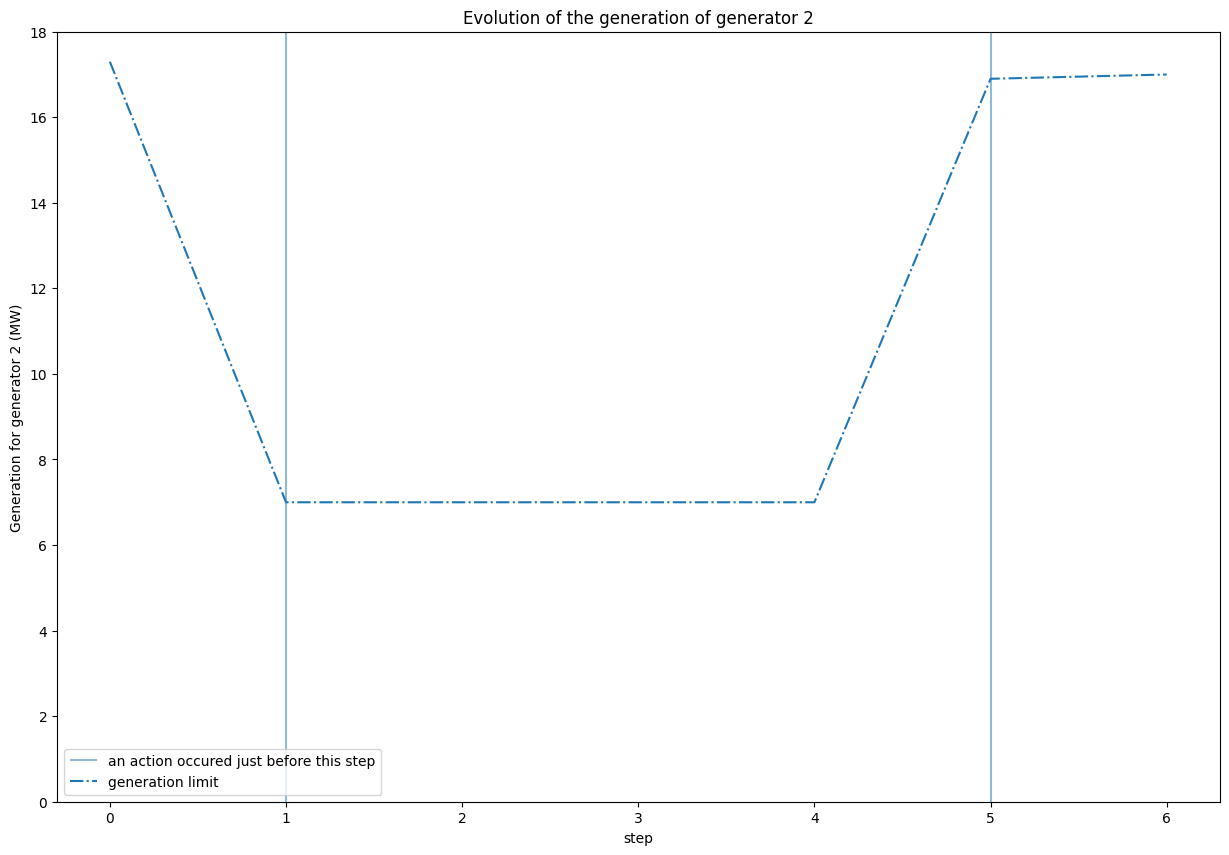

In [24]:
print(f"Curtailment setpoint for generator {gen_id}: {obs.curtailment_limit[gen_id]:.2f} "
      f"({obs.curtailment_limit_mw[gen_id]:.2f} MW)")

# we perform a do nothing action
obs0, *_ = env1.step(env1.action_space())
print(f"Curtailment setpoint for generator {gen_id} (after do nothing action): "
      f"{obs0.curtailment_limit[gen_id]:.2f} "
      f"({obs0.curtailment_limit_mw[gen_id]:.2f} MW)")
# we perform a do nothing action
obs1, *_ = env1.step(env1.action_space())
print(f"Curtailment setpoint for generator {gen_id} (after a second do nothing action): "
      f"{obs1.curtailment_limit[gen_id]:.2f} "
      f"({obs1.curtailment_limit_mw[gen_id]:.2f} MW)")
# we perform a do nothing action
obs2, *_ = env1.step(env1.action_space())
print(f"Curtailment setpoint for generator {gen_id} (after a third do nothing action): "
      f"{obs2.curtailment_limit[gen_id]:.2f} "
      f"({obs2.curtailment_limit_mw[gen_id]:.2f} MW)")

# we perform an action to remove the curtailment
curtail_act_reset = env1.action_space({"curtail": [(gen_id, 1.0)]})
obs3, *_ = env1.step(curtail_act_reset)
print(f"Curtailment setpoint for generator {gen_id} (after setting the curtailment to 100% again): "
      f"{obs3.curtailment_limit[gen_id]:.2f} "
      f"({obs3.curtailment_limit_mw[gen_id]:.2f} MW)")

# we perform another do nothing action
obs4, *_ = env1.step(env1.action_space())
print(f"Curtailment setpoint for generator {gen_id} (after a third do nothing action): "
      f"{obs4.curtailment_limit[gen_id]:.2f} "
      f"({obs4.curtailment_limit_mw[gen_id]:.2f} MW)")

# and we can even plot it to see what's going on
plt.figure(figsize=(15,10))
plt.vlines(list([1, 5]), ymin=0., ymax=18, label="an action occured just before this step", alpha=0.5)
plt.plot([obs_init.gen_p[gen_id],
          obs.gen_p[gen_id],
          obs0.gen_p[gen_id],
          obs1.gen_p[gen_id],
          obs2.gen_p[gen_id],
          obs3.gen_p[gen_id],
          obs4.gen_p[gen_id],],
         label="generation limit", linestyle="-.")
plt.legend()
plt.ylim([0., 18])
plt.xlabel("step")
plt.title(f"Evolution of the generation of generator {gen_id}")
_ = plt.ylabel(f"Generation for generator {gen_id} (MW)")

An example of the behaviour of this feature is provided bellow. In this example, we perform 4 curtailment actions at 4 different steps (showed by vertical bars in the final graphs) and show, for generator 2:
- generation limit (this is the maximum allowed by the curtailment)
- effective curtailment (this is the total amount of MW that has been curtailed)
- reference generation (generation there would have been without curtailment)
- actual generation (the generation observed for this generator, the power that is really injected on the grid)
- sum of dispatch (total power absorbed by the dispatchable generator to compensate for the curtailment)

c:\Users\admin\Grid2Op\venv_grid2op\lib\site-packages\grid2op\MakeEnv\Make.py:454: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


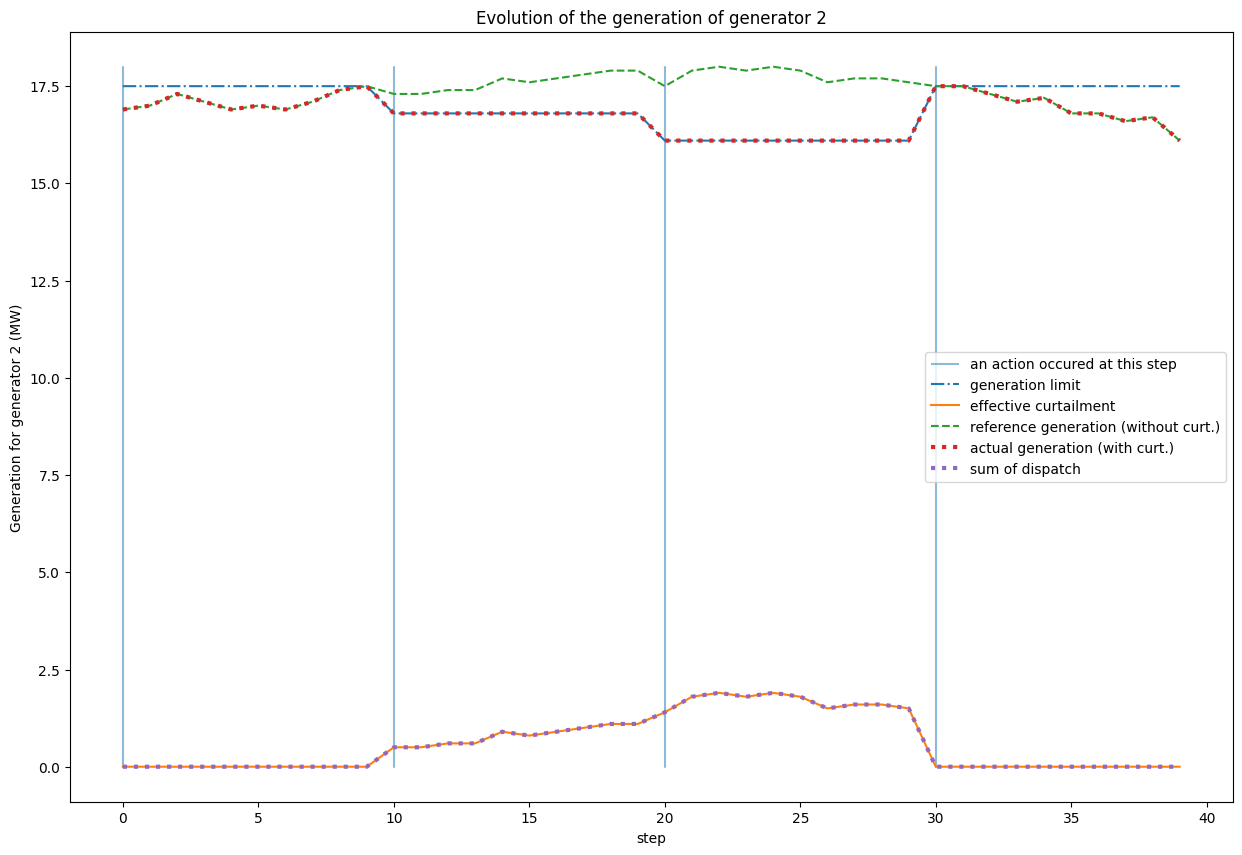

In [25]:
env1 = grid2op.make("educ_case14_storage", 
                    test=True,
                    action_class=PlayableAction,
                    param=param,
                    backend=bk_cls())

gen_id = 2
ratios_max = [0.25, 0.24, 0.23, 0.25]  # don't change it
n_steps = 40 # don't change it
acts = []
prod1 = []
prod2 = []
curtailment_limit = []
curtail_gen1 = []
sum_disp = []
li_id_xplt = set()
for ratio in ratios_max:
    acts.append(env1.action_space({"curtail": [(gen_id, ratio)]}))
    
for step in range(n_steps):
    if step % 10 == 0:
        # execute a curtailment action
        li_id = step // 10
        li_id_xplt.add(step)
        ratio_max = ratios_max[li_id]
        obs1_3, reward1_3, done1_3, info1_3 = env1.step(acts[li_id])
    else:
        obs1_3, reward1_3, done1_3, info1_3 = env1.step(env1.action_space())
        
    if done1_3:
        raise RuntimeError("Environment did game over, this is not normal")
    if info1_3["exception"]:
        raise RuntimeError("Exception for info1_3")

    prod1.append(obs1_3.gen_p[gen_id])
    prod2.append(obs1_3.gen_p_before_curtail[gen_id])
    curtail_gen1.append(obs1_3.curtailment_mw[gen_id])
    curtailment_limit.append(obs1_3.curtailment_limit_mw[gen_id])
    sum_disp.append(obs1_3.actual_dispatch.sum())
    
plt.figure(figsize=(15,10))
plt.vlines(list(li_id_xplt), ymin=0., ymax=18., label="an action occured at this step", alpha=0.5)
plt.plot(curtailment_limit, label="generation limit", linestyle="-.")
plt.plot(curtail_gen1, label="effective curtailment")
plt.plot(prod2, label="reference generation (without curt.)", linestyle="--")
plt.plot(prod1, label="actual generation (with curt.)", linestyle=":", linewidth=3)
plt.plot(sum_disp, label="sum of dispatch", linestyle=":", linewidth=3)
plt.legend()
plt.xlabel("step")
plt.title(f"Evolution of the generation of generator {gen_id}")
_ = plt.ylabel(f"Generation for generator {gen_id} (MW)")

### Important limit to the curtailment

As always in grid2op, we suppose that the "time series data" (the one the agent has no access to, present in the environment and representing the "optimal" generator setpoint from the "market" - or a central authority) are balanced. This means that, without any intervention from any agent, the total generation exactly match the total demand plus the losses.

When an agent perform a redispatching or a curtailment, it will affect this equilibrium. This is why grid2op "compensate" the action of the agent by ensuring that the "global action" (*ie* the sum of all modifications made by the agent) sums up to 0.

To do this, the environment will modify the **controllable** generators. One key consequence is that you can take curtailment action that would "overload" the grid and lead directly to game over.

For example, say an agent curtails 50MW of renewable energy, but the available "ramp up" of controlable generators is only 40MW (*ie* you can increase the controlable generators of at most 40MW between two consecutive steps). In this case the environment cannot simply create the missing 10 MW and it directly lead to a game over, as showed below.

In [26]:
env.set_id(0)
obs = env.reset()
act = env.action_space({"curtail": [(el, 0.) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)
print(f"Is the environment done: {done}")
info

Is the environment done: True


{'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': True,
 'is_illegal_reco': False,
 'reason_alarm_illegal': None,
 'reason_alert_illegal': None,
 'opponent_attack_line': None,
 'opponent_attack_sub': None,
 'opponent_attack_duration': 0,
 'exception': [Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('\nThis is an attempt to explain why the dispatch did not succeed and caused a game over.\nTo compensate the increase of loads and / or decrease of renewable energy (due to naturl causes but also through curtailment) and / or variation in the storage units, the generators should increase their total production of 38.40MW (in total).\nBut, if you take into account the generator constraints (pmax and max_ramp_up) you can have at most 30.00MW.\nIndeed at time t, generators are in state:\n\t[73.2 71.7 70.9]\ntheir ramp max is:\n\t[ 5. 

The same phenomenon occurs when you "undo" the curtailment, for example when you start from a situation where curtailment is really strong (you limited the curtailment to a really low level) and you suddently remove all curtailment, you might end up with issues due to ramps down, as shown bellow:

In [27]:
env.set_id(0)
obs = env.reset()
# gradually decrease the total generation from renewable sources
act = env.action_space({"curtail": [(el, 0.13) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)
act = env.action_space({"curtail": [(el, 0.0) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)

# increase it "at once"
act = env.action_space({"curtail": [(el, 1.) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)
print(f"Is the environment done: {done}")
info

Is the environment done: True


{'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': True,
 'is_illegal_reco': False,
 'reason_alarm_illegal': None,
 'reason_alert_illegal': None,
 'opponent_attack_line': None,
 'opponent_attack_sub': None,
 'opponent_attack_duration': 0,
 'exception': [Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('\nThis is an attempt to explain why the dispatch did not succeed and caused a game over.\nTo compensate the decrease of loads and / or increase of renewable energy (due to naturl causes but also through curtailment) and / or variation in the storage units, the generators should decrease their total production of -35.00MW (in total).\nBut, if you take into account the generator constraints (pmin and max_ramp_down) you can have at most -30.00MW.\nIndeed at time t, generators are in state:\n\t[79.79 84.59 88.32]\ntheir ramp max is:\n

To alleviate this issue, you have two possibilities:
- make the environment more tolerant to these "bad" actions. In this case, the environment will "limit" the amount of MW curtailed in your action (using a heuristic not detailed here) and preventing you to "break" the grid. This can be used only if you create yourself your environment (so this is not suitable at the evaluation time of the l2rpn competitions) and is particularly useful if you envisage "curiculum learning" (*ie* start learning with an easier environment and when your agent achieves good performances change the environment parameters closer to the evaluation parameters)
- do not change the environment at all, but call the `act.limit_curtail_storage(...)` to... limit the curtailment (and the storage) part of your action and keep it "manageable" (hopefully) by the environment.

We explain the two methods in the sub sub sections bellow.

#### modify the parameters of the environment

As you see here, setting the `LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION` to ``True`` solves the issue. 

In [28]:
param = env.parameters
param.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True
env.change_parameters(param)

env.set_id(0)
obs = env.reset()
act = env.action_space({"curtail": [(el, 0.) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)
print(f"Is the environment done: {done}")

# set back the parameters to orignal value
param = env.parameters
param.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = False
env.change_parameters(param)


Is the environment done: False


With this method you should be guaranteed to have a valid action that will not lead to a game over (because of curtailment, you can still "game over" because of every other reasons)

#### modify the action

We developed an method of an action that can limit its impact and keep it "small enough" so that it does not overflow.

To use it you need:
- an observation: it will be used to compute the amount of MW that can be absorbed / produced by the controlable generators
- a "margin": when the limitation is done by the environment, the environment knows exactly the amount of MW the generators can increase or decrease (this is not exactly the ramps because even if the agent does nothing, the generator will increase / decrease their production). If you put the "margin" to 0. (which we do not recommend), the "limit the action" will act as if the generators will not increase / decrease their production. Basically you can think of it of a "safety margin": the higher it is the more your action will be impacted but the less likely

In [29]:
# if you don't limit the action, it breaks
env.set_id(0)
obs = env.reset()
act = env.action_space({"curtail": [(el, 0.) for el in range(env.n_gen) if env.gen_renewable[el]]})
obs, reward, done, info = env.step(act)
print(f"Is the environment done (without the limit_curtail_storage(...) ): {done}")  # of course it is...

# if you limit the action, it's ok
env.set_id(0)
obs = env.reset()
act = env.action_space({"curtail": [(el, 0.) for el in range(env.n_gen) if env.gen_renewable[el]]})
act.limit_curtail_storage(obs, margin=10.)
obs, reward, done, info = env.step(act)
print(f"Is the environment done (with limit_curtail_storage(...) ): {done}")  # of course it is...

# if limit the action, but does not take enough "margin", it breaks again
env.set_id(0)
obs = env.reset()
act = env.action_space({"curtail": [(el, 0.) for el in range(env.n_gen) if env.gen_renewable[el]]})
act.limit_curtail_storage(obs, margin=0.)
obs, reward, done, info = env.step(act)
print(f"Is the environment done (with limit_curtail_storage(...) and not enough margin ): {done}")  # of course it is...

Is the environment done (without the limit_curtail_storage(...) ): True
Is the environment done (with limit_curtail_storage(...) ): False
Is the environment done (with limit_curtail_storage(...) and not enough margin ): True


Nothing prevents you to use the `act.limit_curtail_storage(obs, margin=...)` in your code, when training your agent (for example as a "heuristic" like in the `GymEnvWithRecoWithDN` showed in notebook [04_TrainingAnAgent](./04_TrainingAnAgent.ipynb)). In this case you only need to properly set the `margin` parameter as shown above.